In [1]:
!pip install ibm_db

In [2]:
import ibm_db
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# create a connection to the DSM Historical Repository Database
conn = ibm_db.connect('DATABASE=DSMREPODB; HOSTNAME=9.30.xx.xxx; PORT=50000; PROTOCOL=TCPIP; UID=db2inst1; PWD=xxx', '', '')

In [4]:
# Run to drop a previous view or skip this step
sql="DROP VIEW dbworkloadoverview"
stmt = ibm_db.exec_immediate(conn,sql)

In [5]:
# Create a view of KPIs by database from the DSM Historical Repository
sql="CREATE VIEW dbworkloadoverview AS select week(collected) as week_collected, substr(dbconn_id,1,14) as dbconn_id, substr(workload_name,1,14) as workload_name, date(max(collected)) as end_date, sum(total_cpu_usec_delta) / 1000000.0 as cpu_sec, sum(logical_reads_delta) as logical_reads, sum(act_completed_total_delta) as activities, sum(total_app_commits_delta) as commits from ibm_dsm_views.throughput_workload group by week(collected), dbconn_id, workload_name"
stmt = ibm_db.exec_immediate(conn,sql)

In [6]:
# build a result set from the query and create an array from the result set
sql="select * from dbworkloadoverview where END_DATE > '2017-05-01'"
stmt = ibm_db.exec_immediate(conn,sql)
result = ibm_db.fetch_assoc(stmt)

rows = []
while result:
    rows.append(result)
    result = ibm_db.fetch_assoc(stmt) 

In [7]:
# create a data frame from the array
df = pd.DataFrame(rows)

In [8]:
# display the first few rows of the data frame.
df.head()

,ACTIVITIES,COMMITS,CPU_SEC,DBCONN_ID,END_DATE,LOGICAL_READS,WEEK_COLLECTED,WORKLOAD_NAME
0,15,15,1.18663700000,CommonWorkload,2017-05-06,583,18,DSM_WORKLOAD
1,0,0,0.00000000000,CommonWorkload,2017-05-06,0,18,SYSDEFAULTADMW
2,0,0,0.00000000000,CommonWorkload,2017-05-06,0,18,SYSDEFAULTUSER
3,0,0,0.00000000000,CommonWorkload,2017-05-06,0,18,WL_0
4,0,0,0.00000000000,CommonWorkload,2017-05-06,0,18,WL_1


In [9]:
# create a pivot of the data frame showing the sums of key resources used by database and workload for each week
pd.pivot_table(df,index=["DBCONN_ID","WORKLOAD_NAME","WEEK_COLLECTED"])

ACTIVITIES  COMMITS  \
DBCONN_ID      WORKLOAD_NAME  WEEK_COLLECTED                        
CommonWorkload DSM_WORKLOAD   18                      15       15   
                              19                   16645    10117   
                              20                  886709   656602   
                              21                  890831   656586   
                              22                  203530   154429   
                              23                 1302594  1050326   
                              24                  694302   592562   
                              25                 1242427  1084562   
                              26                 1730891  1520881   
                              27                 1448498  1264249   
                              28                  354231   303317   
               SYSDEFAULTADMW 18                       0        0   
                              19                       0        0   
                              20                       0        0   
                              21                       0        0   
                              22                       0        0   
                              23                       0        0   
                              24                       0        0   
                              25                       0        0   
                              26                       0        0   
                              27                       0        0   
                              28                       0        0   
               SYSDEFAULTUSER 18                       0        0   
                              19                     905      167   
                              20                    2112      693   
                              21                    1889     1890   
                              22                     389      390   
                              23                    2150     2095   
                              24                      42       39   
                              25                     930      795   
...                                                  ...      ...   
dashDB T2      SYSDEFAULTUSER 23                 2107089  1911310   
                              24                 1727859  1563475   
                              25                 1510342  1383828   
                              26                 1836976  1669064   
                              27                 1857255  1674692   
                              28                  457308   414418   
dsm3           SYSDEFAULTADMW 27                       0        0   
                              28                       0        0   
               SYSDEFAULTUSER 27                   65029    48153   
                              28                   66518    52219   
hadr__1        SYSDEFAULTADMW 18                       0        0   
                              19                       0        0   
                              20                       0        0   
                              21                       0        0   
               SYSDEFAULTUSER 18                  365343   366059   
                              19                  742146   743909   
                              20                 1046554  1048968   
                              21                  492108   492961   
pkDB1          DSM_WORKLOAD   20                    2816     1818   
               SYSDEFAULTADMW 20                       0        0   
               SYSDEFAULTUSER 20                     243      245   
pkDB2          SYSDEFAULTADMW 20                       0        0   
               SYSDEFAULTUSER 20                       2        2   
sam1           SYSDEFAULTADMW 24                       0        0   
               SYSDEFAULTUSER 24                       0        0   
sample11122    DSM_WORKLOAD   24            

In [10]:
# create a group by object of the total transactions per database
byDatabase = df.groupby('DBCONN_ID')
# sum the total number of transactions for each database in total
sum_transactions = byDatabase['ACTIVITIES'].aggregate(np.sum)
# sort and display the databases by highest number of transactions
sum_transactions.sort_values(inplace=True, ascending=False)
sum_transactions

DBCONN_ID
Overhead_81       330959217
REPO125           135120861
dashDB T1          22207038
dashDB T2          16650980
CommonWorkload     10683775
REPODB3             8632257
TPCDS-SVL           4364618
hadr__1             2646151
REPODB_YHAN         1302163
YHAN_REPODB          606974
PKDB1                401136
TEST                 297018
sample11122          203520
TEST61               155417
dsm3                 131547
PKDB2                105238
yhan_REPODB3          87936
corporate             28899
bigsql32051           24488
cbx                   12115
pkDB1                  3059
DSMDBTESTCONN            78
DSMDB                    77
pkDB2                     2
sam1                      0
INF_LUW_111_01            0
TT                        0
Name: ACTIVITIES, dtype: int64

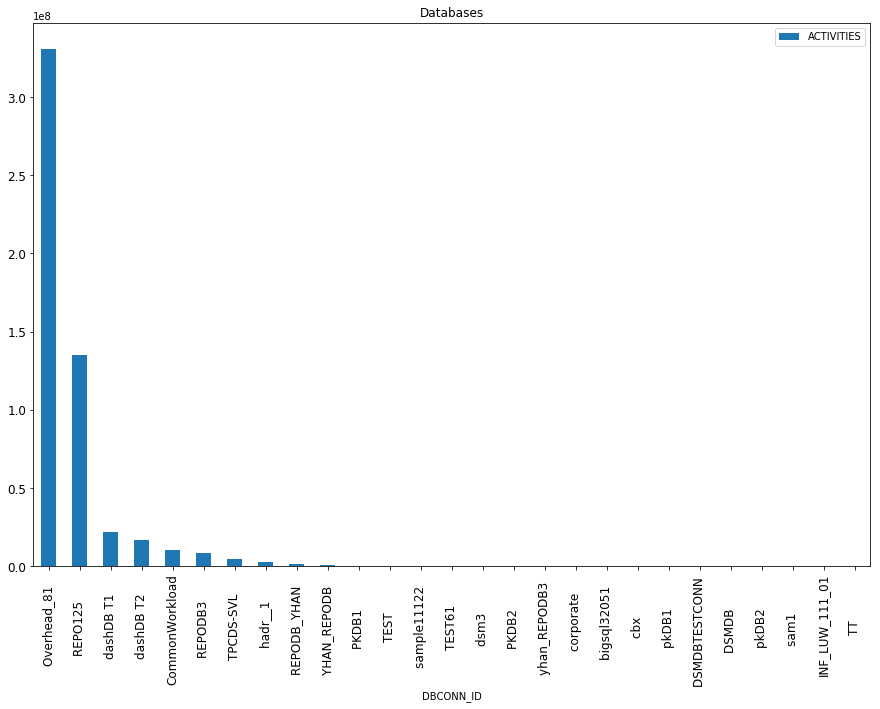

In [11]:
# graph the transactions per database
sum_transactions.plot(x='DBCONN_ID',y='ACTIVITIES',kind='bar', title ="Databases", figsize=(15, 10), legend=True, fontsize=12)
plt.show()